In [3]:
from matplotlib.colors import BoundaryNorm
import seaborn as sns
import numpy as np

In [4]:
def space(n: int) -> int:
    if n == 0:
        return 0
    return 2**(n-1)

def haloRad(r : int, n: int) -> int:
    return r*(1+space(n))

def tileRad(r: int, n: int, b: int) -> int:
    return 2*haloRad(r, n) + b

In [5]:
def compute_occupancy(
    threads_per_block,
    registers_per_thread,
    shared_mem_per_block,
    gpu
):

    blocks_threads = gpu['maxThreadsPerSM'] // threads_per_block
    blocks_limit = gpu['maxBlocksPerSM']
    blocks_shared = gpu['maxSharedMemPerSM'] // shared_mem_per_block if shared_mem_per_block > 0 else blocks_limit

    regs_per_block = registers_per_thread * threads_per_block
    blocks_registers = gpu['maxRegistersPerSM'] // regs_per_block if regs_per_block > 0 else blocks_limit

    blocks_per_sm = min(blocks_threads, blocks_limit, blocks_shared, blocks_registers)

    warps_per_block = int(np.ceil(threads_per_block / 32))
    total_warps = blocks_per_sm * warps_per_block

    occupancy = min(total_warps / gpu['maxWarpsPerSM'], 1.0)

    return {
        'blocks_due_to_threads': blocks_threads,
        'blocks_due_to_shared': blocks_shared,
        'blocks_due_to_registers': blocks_registers,
        'blocks_final': blocks_per_sm,
        'warps_per_block': warps_per_block,
        'total_warps': total_warps,
        'occupancy': occupancy
    }


In [6]:
gpu = {
    'maxThreadsPerSM': 1024,
    'maxThreadsPerBlock': 1024,
    'maxBlocksPerSM': 16,
    'maxWarpsPerSM': 64,
    'maxRegistersPerSM': 65536,
    'maxRegistersPerThread': 255,
    'maxSharedMemPerSM': 64*1024,
    'maxSharedMemPerBlock': 48*1024
}

# Example usage
result = compute_occupancy(
    threads_per_block=256,
    registers_per_thread=32,
    shared_mem_per_block=4096,
    gpu=gpu
)

print(result['occupancy'])

0.5


## Tile Size

In [7]:
r = 2
bx, by = (32, 8)


print('Idx','Bx', 'By', 'Halo', 'Tile X', 'Tile Y', 'Area', 'KB', sep='\t')

for dilation in range(5):
    halo = r*2**dilation

    tx, ty = bx + 2*halo, by + 2*halo
    tileArea = tx*ty
    tileMem = 4*tileArea
    occ = compute_occupancy(
        threads_per_block=1,
        registers_per_thread=1,
        shared_mem_per_block=tileMem,
        gpu=gpu
    )['occupancy']

    print(dilation, bx, by, halo, tx, ty, tileArea, tileMem, occ, sep='\t')

Idx	Bx	By	Halo	Tile X	Tile Y	Area	KB
0	32	8	2	36	12	432	1728	0.25
1	32	8	4	40	16	640	2560	0.25
2	32	8	8	48	24	1152	4608	0.21875
3	32	8	16	64	40	2560	10240	0.09375
4	32	8	32	96	72	6912	27648	0.03125


In [8]:
print('Idx', 'Space', 'Halo R', 'Tile D', 'Area', 'KB (b)', 'KB (3b)', sep='\t')
r = 2
b = 16
for n in range(0,9):
    s = space(n)
    d = haloRad(r, n)
    t = tileRad(r, n, b)
    a = t**2
    kb = a/1024
    kb3 = 3*kb

    if s == b: 
        print('>=5', s, d, t, a, f'{kb:.2f}', f'{kb3:.2f}', sep='\t')
        break

    print(n, s, d, t, a, f'{kb:.2f}', f'{kb3:.2f}', sep='\t')

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
0	0	2	20	400	0.39	1.17
1	1	4	24	576	0.56	1.69
2	2	6	28	784	0.77	2.30
3	4	10	36	1296	1.27	3.80
4	8	18	52	2704	2.64	7.92
>=5	16	34	84	7056	6.89	20.67


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

r = 2
b = 16
n = 3

access = {}

for bx in range(b):
    for by in range(b):
        for dx in range(-r, r+1):
            for dy in range(-r, r+1):
                pos = (bx+dx*(1+space(n)), by+dy*(1+space(n)))
                if not pos in access:
                    access[pos] = 0
                
                access[pos] += 1

xs = [x for x, _ in access.keys()]
ys = [y for _, y in access.keys()]

x_min, x_max = min(xs), max(xs)
y_min, y_max = min(ys), max(ys)

# Build 2D array (note: adjust origin if needed)
grid = np.full((y_max - y_min + 1, x_max - x_min + 1), 0)
for (x, y), val in access.items():
    grid[y - y_min, x - x_min] = val


In [10]:
def plotGrid(grid, cmap = 'Blues'):
    cmap = plt.get_cmap(cmap)
    levels = np.arange(grid.min(), grid.max() + 2)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    ax = sns.heatmap(
        grid,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        linecolor='white')
    
    ax.set_xticks([])
    ax.set_yticks([])

    # Add border via spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    plt.title("Tile access")
    plt.show()

In [11]:
def dict_to_grid(d):
    xs = [x for x, _ in d.keys()]
    ys = [y for _, y in d.keys()]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Build 2D array (note: adjust origin if needed)
    grid = np.full((y_max - y_min + 1, x_max - x_min + 1), 0)
    for (x, y), val in d.items():
        grid[y - y_min, x - x_min] = val

    return grid

(16, 16) (120, 68)


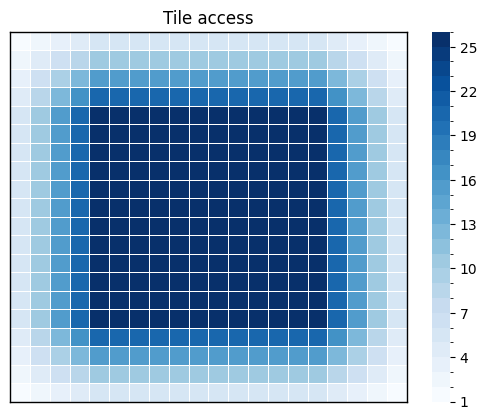

In [12]:
imgShape = (1920, 1080)
blockShape = (16, 16)
gridShape = ((imgShape[0] + blockShape[0]-1)//blockShape[0], (imgShape[1] + blockShape[1]-1)//blockShape[1])

print(blockShape, gridShape)

data = np.zeros(blockShape)
data = {}

r = 2
n = 0
for bx in range(blockShape[0]):
    for by in range(blockShape[0]):
        tid = by * blockShape[0] + bx
        wid = tid%32
        warp = tid//32

        for dx in range(-r, r+1):
            for dy in range(-r, r+1):
                pos = (bx+dx*(1+space(n)), by+dy*(1+space(n)))

                if not pos in data:
                    data[pos] = 0

                data[pos] += 1


grid = dict_to_grid(data)
plotGrid(grid)


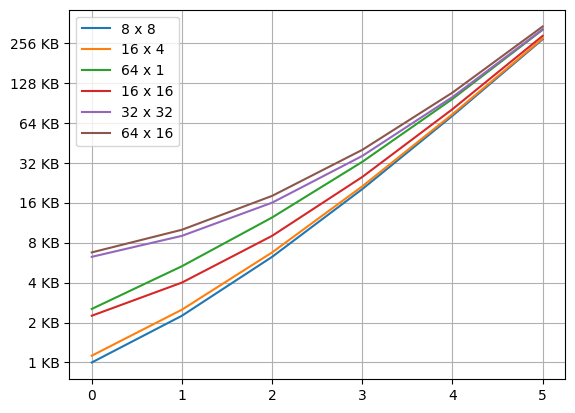

In [73]:
r = 2
#Bx, By = 32, 32

for Bx, By in [(8,8), (16,4), (64,1), (16,16), (32, 32), (64, 16)]:
    #By = 256//Bx
    k = np.array([0,1,2,3,4,5])

    h = 2**(k+2)*r
    #h = np.clip(h,0,min(Bx,By))
    A = (Bx + h)*(By+h)
    M = 4*A/1024

    plt.semilogy(M, base=2, label=f'{Bx} x {By}')
    import matplotlib.ticker as ticker
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d KB'))
    
    
    #plt.yscale('log', base=2)
    plt.legend()
#plt.axhline(y=48, color='red', linestyle='--', linewidth=1)
plt.grid()

In [104]:
blocks = [(8,8), (16,16), (32, 1), (32, 4), (32, 16), (32, 32), (64, 16), (128, 8), (256, 4)]

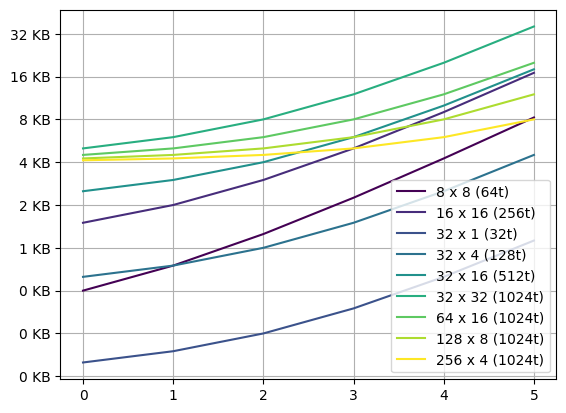

In [108]:
r = 2

cmap = plt.get_cmap('viridis')
colors = [cmap(i / (len(blocks)-1)) for i in range(len(blocks))]
i = 0
for Bx, By in blocks:
    tcount = Bx*By
    k = np.array([0,1,2,3,4,5])

    h = 2**(k+2)*r
    #h = np.clip(h,0,min(Bx,By))
    A = (Bx + h)*By
    M = 4*A/1024

    plt.semilogy(M, base=2, label=f'{Bx} x {By} ({tcount}t)', color=colors[i])
    import matplotlib.ticker as ticker
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d KB'))
    
    
    #plt.yscale('log', base=2)
    plt.legend()
    i += 1
#plt.axhline(y=48, color='red', linestyle='--', linewidth=1)
plt.grid()

# Cases

In [14]:
r = 2
def print_stats(b):
    bx, by = b

    print('Idx', 'Halo', 'Tile X', 'Tile Y', 'Area', 'KB', sep='\t')

    for dilation in range(5):
        halo = r*2**dilation

        tx, ty = bx + 2*halo, by + 2*halo
        tileArea = tx*ty
        tileMem = 4*tileArea
        occ = compute_occupancy(
            threads_per_block=1,
            registers_per_thread=1,
            shared_mem_per_block=tileMem,
            gpu=gpu
        )['blocks_due_to_shared']

        print(dilation, halo, tx, ty, tileArea, tileMem, occ, sep='\t')

In [15]:
a = 256
b = 4*a
bt = b*2
blim = 48*1024//bt

s, a, b, bt, blim

(16, 256, 1024, 2048, 24)

## 32 X 8

In [16]:
print_stats((32,8))

Idx	Halo	Tile X	Tile Y	Area	KB
0	2	36	12	432	1728	37
1	4	40	16	640	2560	25
2	8	48	24	1152	4608	14
3	16	64	40	2560	10240	6
4	32	96	72	6912	27648	2


Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
0	0	2	36	1296	1.27	3.80
Average access 19.753086419753085


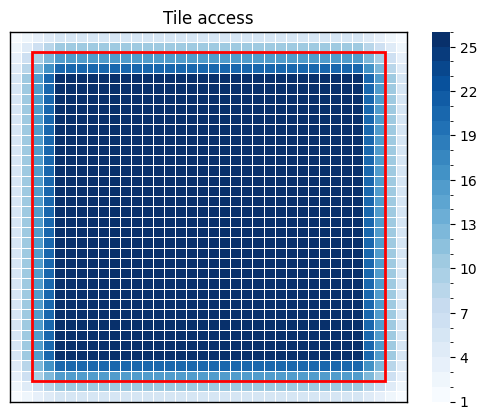

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
1	1	4	40	1600	1.56	4.69
Average access 16.0


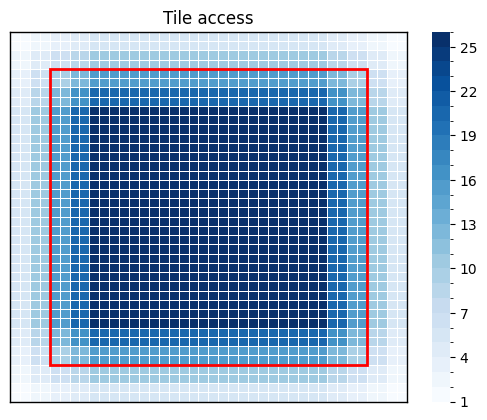

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
2	2	6	44	1936	1.89	5.67
Average access 13.223140495867769


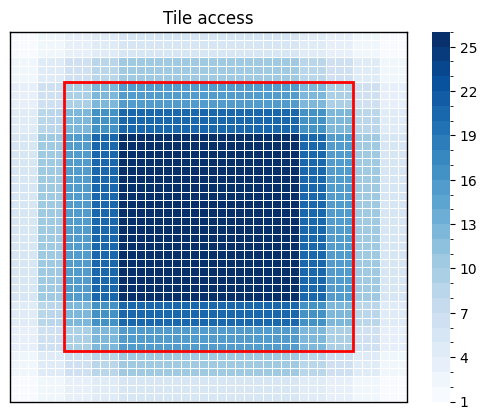

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
3	4	10	52	2704	2.64	7.92
Average access 9.467455621301776


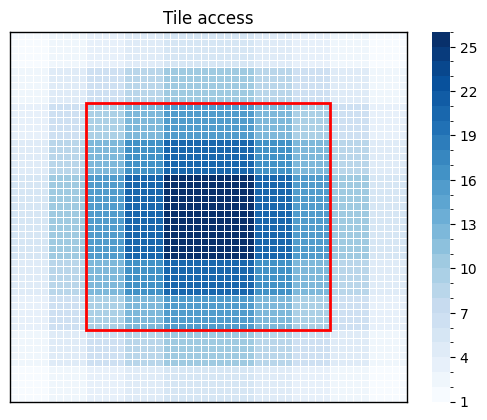

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
4	8	18	68	4624	4.52	13.55
Average access 5.536332179930795


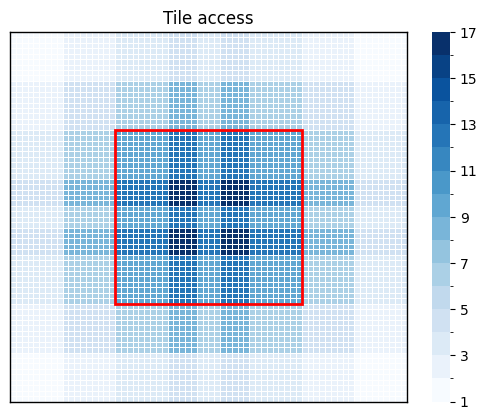

Idx	Space	Halo R	Tile D	Area	KB (b)	KB (3b)
5	16	34	100	10000	9.77	29.30
Average access 2.56


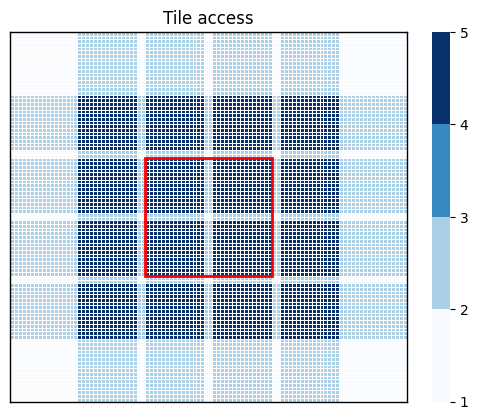

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np

k = 5
r = 2
b = 1<<k
for n in range(k+1):
    s = space(n)
    d = haloRad(r, n)
    t = tileRad(r, n, b)
    a = t**2
    kb = a/1024
    kb3 = 3*kb

    print('Idx', 'Space', 'Halo R', 'Tile D', 'Area', 'KB (b)', 'KB (3b)', sep='\t')

    if s == b: 
        print('>=5', s, d, t, a, f'{kb:.2f}', f'{kb3:.2f}', sep='\t')
        break

    print(n, s, d, t, a, f'{kb:.2f}', f'{kb3:.2f}', sep='\t')
    
    access = {}

    for bx in range(b):
        for by in range(b):
            for dx in range(-r, r+1):
                for dy in range(-r, r+1):
                    pos = (bx+dx*(1+space(n)), by+dy*(1+space(n)))
                    if not pos in access:
                        access[pos] = 0
                    
                    access[pos] += 1
            


    #assert(len(access) == a)

    xs = [x for x, _ in access.keys()]
    ys = [y for _, y in access.keys()]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Build 2D array (note: adjust origin if needed)
    grid = np.full((y_max - y_min + 1, x_max - x_min + 1), 0)
    for (x, y), val in access.items():
        grid[y - y_min, x - x_min] = val

    print('Average access', grid.mean())
        
    cmap = plt.get_cmap("Blues")
    levels = np.arange(grid.min(), grid.max() + 2)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    ax = sns.heatmap(
        grid,
        cmap="Blues",
        norm=norm,
        linewidths=0.5,
        linecolor='white')

    rect = patches.Rectangle((haloRad(r,n), haloRad(r,n)), b, b, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    ax.set_xticks([])
    ax.set_yticks([])

    # Add border via spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    plt.title("Tile access")
    plt.show()